# Préparation & preprocessing

In [19]:
# ---
# 1) Préparation : imports, chargement des données, preprocessing
# ---

import os, urllib.request, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Dataset
CSV_NAME  = "/content/WA_Fn-UseC_-HR-Employee-Attrition.csv"

# Chargement + nettoyage très léger
df = pd.read_csv(CSV_NAME).copy()
df["Attrition"] = df["Attrition"].map({"Yes":1, "No":0})

# on retire les colonnes inutiles (ID/constantes)
drop_cols = [c for c in ["EmployeeCount","Over18","StandardHours","EmployeeNumber"] if c in df.columns]
df = df.drop(columns=drop_cols)

# Split features / cible
y = df["Attrition"].values
X = df.drop(columns=["Attrition"])

# Colonnes catégorielles vs numériques
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

# Préprocesseur = OneHotEncoder + StandardScaler
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >=1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # compat anciennes versions

prepro = ColumnTransformer([
    ("cat", ohe, cat_cols),
    ("num", StandardScaler(), num_cols)
])

# CV stratifée (class imbalance)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"X shape = {X.shape} | y positifs = {y.sum()} / {len(y)}")

X shape = (1470, 30) | y positifs = 237 / 1470


# Baselines : LogReg, Tree, RF, KNN (+ métriques utiles)

In [20]:
# ---
# 2) Baselines : on évalue 4 modèles avec les mêmes features
# KPIs : PR-AUC (adapté aux classes déséquilibrées), F1@0.5,
#        meilleur F1 (et son seuil) pour montrer l’optimisation métier.
# ---

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    average_precision_score, precision_recall_curve,
    f1_score, brier_score_loss
)

np.random.seed(42)

models = {
    "LogReg": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "Tree":   DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "RF":     RandomForestClassifier(n_estimators=400, class_weight="balanced", random_state=42, n_jobs=-1),
    "KNN":    KNeighborsClassifier(n_neighbors=25)
}

def eval_pipe(name, clf):
    pipe = Pipeline([("prep", prepro), ("clf", clf)])
    proba = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:,1]
    ap = average_precision_score(y, proba)             # PR-AUC
    f1_05 = f1_score(y, (proba>=0.5).astype(int))      # F1 à 0.5 pour se faire une idée

    p, r, thr = precision_recall_curve(y, proba)       # on cherche aussi le meilleur F1
    f1s = (2*p*r) / (p + r + 1e-12)
    best_idx = int(np.nanargmax(f1s))
    best_f1  = float(f1s[best_idx])
    best_thr = 0.0 if best_idx==0 else float(thr[best_idx-1])

    brier = brier_score_loss(y, proba)                 # calibration globale

    return {
        "name": name, "pipe": pipe, "proba": proba,
        "PR_AUC": ap, "F1@0.5": f1_05, "BestF1": best_f1, "BestThr": best_thr,
        "p": p, "r": r, "brier": brier
    }

baseline_results = [eval_pipe(n, m) for n,m in models.items()]
baseline_results = sorted(baseline_results, key=lambda d: d["PR_AUC"], reverse=True)

# Petit tableau récap
import pandas as pd
baseline_table = pd.DataFrame([
    {"Model": r["name"], "PR-AUC": round(r["PR_AUC"],3), "F1@0.5": round(r["F1@0.5"],3),
     "BestF1": round(r["BestF1"],3), "BestThr": round(r["BestThr"],2), "Brier": round(r["brier"],3)}
    for r in baseline_results
])
baseline_table

,Model,PR-AUC,F1@0.5,BestF1,BestThr,Brier
0,LogReg,0.578,0.481,0.545,0.71,0.160
1,RF,0.536,0.236,0.531,0.22,0.106
2,KNN,0.423,0.033,0.426,0.16,0.119
3,Tree,0.216,0.331,0.331,0.00,0.220


# Courbe PR + calibration (les deux graphes “qui parlent”)

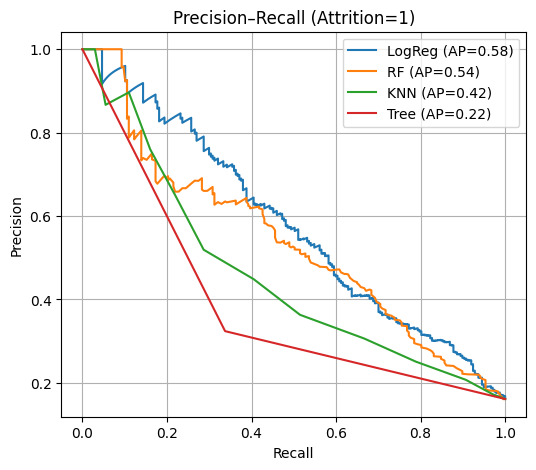

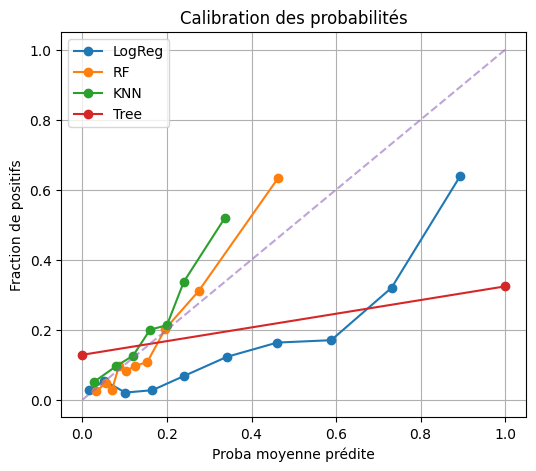

In [21]:
# ---
# 3) Visualisations minimales :
# - Precision–Recall → montre la performance quand la classe 1 est rare
# - Calibration → montre si les proba sont bien “dosées”
# ---

plt.figure(figsize=(6,5))
for r in baseline_results:
    plt.plot(r["r"], r["p"], label=f'{r["name"]} (AP={r["PR_AUC"]:.2f})')
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall (Attrition=1)")
plt.grid(True); plt.legend(); plt.show()

from sklearn.calibration import calibration_curve

plt.figure(figsize=(6,5))
for r in baseline_results:
    frac_pos, mean_pred = calibration_curve(y, r["proba"], n_bins=10, strategy="quantile")
    plt.plot(mean_pred, frac_pos, marker='o', label=r["name"])
plt.plot([0,1],[0,1],'--', alpha=0.6)
plt.xlabel("Proba moyenne prédite"); plt.ylabel("Fraction de positifs")
plt.title("Calibration des probabilités"); plt.grid(True); plt.legend(); plt.show()

# Optimisation rapide (RandomizedSearchCV) : LogReg + RF

In [22]:
# ---
# 4) Optimisation “propre” : on tune LogReg et RF avec RandomizedSearchCV
# Scoring = average_precision (PR-AUC) → adapté au déséquilibre.
# ---

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint

# LogReg : on explore L1/L2 et C (log uniforme)
logreg_pipe = Pipeline([("prep", prepro),
                        ("clf", LogisticRegression(solver="saga", max_iter=4000, class_weight="balanced"))])
logreg_space = {
    "clf__penalty": ["l1", "l2"],
    "clf__C": loguniform(1e-3, 1e2),
}

rs_logreg = RandomizedSearchCV(
    logreg_pipe, logreg_space, n_iter=20, scoring="average_precision",
    cv=cv, n_jobs=-1, random_state=42, refit=True
)
rs_logreg.fit(X, y)
print("Best LogReg params:", rs_logreg.best_params_)
print(f"Best LogReg PR-AUC (CV) = {rs_logreg.best_score_:.3f}")

# RF : on explore profondeur / nb arbres / splits / feuilles / max_features
rf_pipe = Pipeline([("prep", prepro),
                    ("clf", RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1))])
rf_space = {
    "clf__n_estimators": randint(200, 800),
    "clf__max_depth": randint(3, 20),
    "clf__min_samples_split": randint(2, 20),
    "clf__min_samples_leaf": randint(1, 10),
    "clf__max_features": ["sqrt", "log2", None],
}

rs_rf = RandomizedSearchCV(
    rf_pipe, rf_space, n_iter=25, scoring="average_precision",
    cv=cv, n_jobs=-1, random_state=42, refit=True
)
rs_rf.fit(X, y)
print("Best RF params:", rs_rf.best_params_)
print(f"Best RF PR-AUC (CV) = {rs_rf.best_score_:.3f}")

Best LogReg params: {'clf__C': np.float64(0.04661686413912769), 'clf__penalty': 'l2'}
Best LogReg PR-AUC (CV) = 0.617
Best RF params: {'clf__max_depth': 10, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 17, 'clf__n_estimators': 702}
Best RF PR-AUC (CV) = 0.571


# Comparatif baseline vs tuned + choix du modèle final

In [23]:
# ---
# 5) On compare : meilleur baseline vs modèles tunés
# Puis on retient le meilleur pipeline et on le fit sur tout le dataset.
# ---

# PR-AUC des baselines (déjà calculés)
best_baseline = baseline_results[0]
ap_baseline   = best_baseline["PR_AUC"]
name_baseline = best_baseline["name"]

# PR-AUC des tunés (issus directement de CV)
ap_logreg_tuned = rs_logreg.best_score_
ap_rf_tuned     = rs_rf.best_score_

comp = pd.DataFrame([
    {"Model":"Best baseline ("+name_baseline+")", "PR-AUC (CV)": round(ap_baseline,3)},
    {"Model":"LogReg (tuned)", "PR-AUC (CV)": round(ap_logreg_tuned,3)},
    {"Model":"RF (tuned)",     "PR-AUC (CV)": round(ap_rf_tuned,3)},
]).sort_values("PR-AUC (CV)", ascending=False).reset_index(drop=True)

display(comp)

# Choix final
cand_models = [
    (name_baseline, best_baseline["pipe"]),           # baseline pipe (structure)
    ("LogReg (tuned)", rs_logreg.best_estimator_),
    ("RF (tuned)", rs_rf.best_estimator_),
]

# On choisit celui au meilleur PR-AUC CV (déjà trié dans comp)
final_name = comp.iloc[0]["Model"]
final_pipe = dict(cand_models)[final_name]
final_pipe.fit(X, y)
print(f"✅ Modèle final retenu : {final_name}")

,Model,PR-AUC (CV)
0,LogReg (tuned),0.617
1,Best baseline (LogReg),0.578
2,RF (tuned),0.571


✅ Modèle final retenu : LogReg (tuned)


# Seuil “métier” (coût FN >> FP) + quelques chiffres simples

In [24]:
# ---
# 6) Seuil métier : on veut éviter surtout les départs non détectés (FN).
# On choisit le seuil qui minimise :  coût = 10*FN + 1*FP  (modifiable)
# ---

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# On obtient des proba en cross-val pour estimer le bon seuil (pas optimiste)
proba_oof_final = cross_val_predict(final_pipe, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:,1]

def best_threshold_by_cost(y_true, proba, cost_fn=10.0, cost_fp=1.0, grid=201):
    ts = np.linspace(0,1,grid)
    best_t, best_c = 0.5, np.inf
    for t in ts:
        pred = (proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
        cost = cost_fn*fn + cost_fp*fp
        if cost < best_c:
            best_c, best_t = cost, t
    return float(best_t), float(best_c)

thr_opt, cmin = best_threshold_by_cost(y, proba_oof_final, cost_fn=10.0, cost_fp=1.0)
print(f"Seuil optimal ≈ {thr_opt:.2f} (coût min = {cmin:.1f})")

# Avec ce seuil, on regarde précision / rappel / F1 (toujours sur OOF)
pred_oof = (proba_oof_final >= thr_opt).astype(int)
print(f"Precision={precision_score(y, pred_oof):.2f} | Recall={recall_score(y, pred_oof):.2f} | F1={f1_score(y, pred_oof):.2f}")

Seuil optimal ≈ 0.39 (coût min = 837.0)
Precision=0.30 | Recall=0.84 | F1=0.45
